<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/ml0/MachineLearning/Intro_ML.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>
    <div align="center"> Recordá abrir en una nueva pestaña </div>
    

## Sci-kit Learn

La librería [sci-kit learn](https://scikit-learn.org/stable/) es una ámpliamente utilizada para prototipado y desarrollo de modelos de Machine Learning. 

Este paquete nos ofrece versiones eficientes de una gran variedad de algoritmos, accesibles mediante una API homogénea que facilita el desarrollo y permite probar distintos algorítmos con mínima modificación del código.



<img src='https://scikit-learn.org/stable/_static/ml_map.png' width=800px>

Podemos ver el [índice de algoritmos en sklearn](https://scikit-learn.org/stable/user_guide).

En el desarrollo de sci-kit, se tuvieron en cuenta algunos principios:
- Consistencia: todos los objetos comparten una inferfaz uniforme
- Inspección: podemos acceder a los parámetros como atributos públicos
- Jerarquía limitada de objetos: solo los algorítmos se representan como clases de Python, mientras que los datasets utilizan formatos estándar: Numpy Arrays, DataFrames de Pandas, y matrices de SciPy.
- Composición: permitiendo siempre que es posible la concatenación de procesos en secuencias
- Valores default apropiados: en el caso de hiperparámetros necesarios en los modelos

Para más detalle consultar el [paper de sklearn](https://arxiv.org/abs/1309.0238)

Todo este repertorio de estimadores va a usar la misma inferfaz, o API, que se ve algo así:

```python
from sklearn.familia_de_modelos import Modelo
mi_modelo = Modelo(hiperparámetros)
mi_modelo.fit(X, y)

predicción = mi_modelo.predict(nuevo_X)
```

Para ajustar nuestros modelos de machine learning, la _Estimator API_ de sklearn toma una matriz de features **X** y un vector **y** (en el caso de ML supervisado), donde **X** tiene la forma ``(n_observaciones, n_variables)`` e **y** ``(n_observaciones)``

![](https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/figures/05.02-samples-features.png)

Ejercicio para pensar: 

¿Cómo querríamos que sea la matriz **X**? 

¿Qué preprocesamiento podríamos necesitar hacer?

¿Cómo sería en el caso de trabajar con...
- Variables Categóricas?
- Datos desbalanceados?
- Texto?
- Imagenes?

#### Vamos por un primer ejemplo

## Machine learning from disaster

En esta notebook vamos a analizar los datos de sobrevivientes del Titanic y a construir un pipeline de inferencia que nos permita predecir cuál era la probabilidad de sobrevivir de cada pasajero.

Finalmente, vamos a evaluar cuál era la probabilidad de supervivencia de los protagonistas de la película: Jack y Rose. 

In [ ]:
# Descargamos dataset 
!wget https://datasets-humai.s3.amazonaws.com/datasets/titanic.csv

--2020-11-10 19:35:24--  https://datasets-humai.s3.amazonaws.com/datasets/titanic.csv
Resolving datasets-humai.s3.amazonaws.com (datasets-humai.s3.amazonaws.com)... 52.217.98.108
Connecting to datasets-humai.s3.amazonaws.com (datasets-humai.s3.amazonaws.com)|52.217.98.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60326 (59K) [text/csv]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  58.91K   163KB/s    in 0.4s    

2020-11-10 19:35:26 (163 KB/s) - ‘titanic.csv’ saved [60326/60326]



Las variables con las que contamos son:
```Pclass Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
survival: Survival (0 = No; 1 = Yes)
name: Name
sex: Sex
age: Age
sibsp: Number of Siblings/Spouses Aboard
parch: Number of Parents/Children Aboard
ticket: Ticket Number
fare: Passenger Fare (British pound)
cabin: Cabin
embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
boat: Lifeboat
body: Body Identification Number
home.dest: Home/Destination
```



### Análisis exploratorio de datos

In [ ]:
# Ya conocidas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocesamiento
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Entrenamiento
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

In [ ]:
# Leemos dataset
df = pd.read_csv('titanic.csv',sep='|')

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Evaluando el balanceo de la clase

La primera pregunta: ¿Cuántos casos tenemos de cada clase? Si los datos están muy desbalanaceados podemos evaluar técnicas de Resampling.

In [ ]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Otras exploraciones de los datos

In [ ]:
df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

¿Cuántos pasajeros había en cada clase?

In [ ]:
df['Pclass'].value_counts(normalize=True)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

¿Cuántos son hombres y cuántos mujeres?

In [ ]:
df['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [ ]:
df['Embarked'].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

¿Cómo se distribuye la edad?

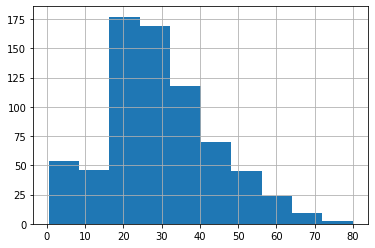

In [ ]:
df['Age'].hist();

¿Cómo se distribuye la tarifa pagada?

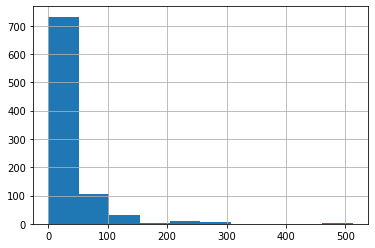

In [ ]:
df['Fare'].hist();

#### Descartando variables específicas

El ID de pasajero, el número de ticket y el número de cabina son variables demasiado específicas como para aprovecharlas en una predicción. Podemos descartarlas. Lo mismo podemos decir del nombre. 


In [ ]:
df = df.drop(['PassengerId','Cabin','Ticket','Name'],axis=1)

#### Calculando las variables Dummy

Ahora tenemos que transformar las categóricas en representaciones numéricas que nuestro algoritmo pueda entender. 


In [ ]:
df_dummies = pd.get_dummies(df)

In [ ]:
df_dummies.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


### Matriz de correlaciones


In [ ]:
corr = df_dummies.corr()
corr.style.background_gradient(cmap='coolwarm')

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.543351,-0.543351,0.168240,0.003650,-0.155660
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.131900,0.131900,-0.243292,0.221009,0.081720
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.093254,0.093254,0.036261,-0.022405,-0.032523
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.114631,-0.114631,-0.059528,-0.026354,0.070941
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.245489,-0.245489,-0.011069,-0.081228,0.063036
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.182333,-0.182333,0.269335,-0.117216,-0.166603
Sex_female,0.543351,-0.131900,-0.093254,0.114631,0.245489,0.182333,1.000000,-1.000000,0.082853,0.074115,-0.125722
Sex_male,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,-1.000000,1.000000,-0.082853,-0.074115,0.125722
Embarked_C,0.168240,-0.243292,0.036261,-0.059528,-0.011069,0.269335,0.082853,-0.082853,1.000000,-0.148258,-0.778359
Embarked_Q,0.003650,0.221009,-0.022405,-0.026354,-0.081228,-0.117216,0.074115,-0.074115,-0.148258,1.000000,-0.496624


### Revisión de valores faltantes

Evaluemos ahora los valores faltantes. Una buena estrategia de imputación para empezar es reemplazar los valores faltantes en columnas numéricas con la mediana y en columnas categóricas con el valore más frecuente. 

In [ ]:
df.isnull().sum(axis = 0)

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

### Separación de datos entre train y test

In [ ]:
X = df.drop('Survived',axis=1)
y = df['Survived']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Pipeline de inferencia

Para tener un modelo robusto, necesitamos crear un pipeline de inferencia que realice todos los pasos necesarios de pre-procesamiento (por ejemplo el cálculo de variables dummies) y realice también la imputación cuando los datos son faltantes. 

In [ ]:
numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_features = ['Embarked', 'Sex', 'Pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])



clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

### Predicción sobre los datos de prueba y evaluación del modelo

In [ ]:
predicciones = clf.predict_proba(X_test)

In [ ]:
predicciones.shape

(179, 2)

In [ ]:
# Vamos a quedarnos con todas las filas y la primera columna
preds_proba = predicciones[:,1]

In [ ]:
preds_proba

In [ ]:
preds_exacta = predicciones.argmax(axis=1)

In [ ]:
preds_exacta

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0])

#### Matriz de confusión

In [ ]:
df_cm = confusion_matrix(y_test.values, preds_exacta)

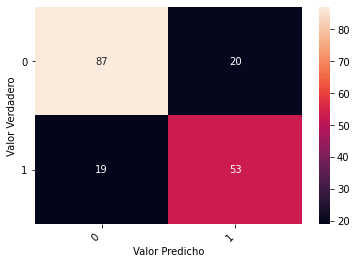

In [ ]:
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels([0,1], rotation=0, ha='right')
heatmap.xaxis.set_ticklabels([0,1], rotation=45, ha='right')
plt.ylabel('Valor Verdadero')
plt.xlabel('Valor Predicho');

### Reporte de clasificación

In [ ]:
print(classification_report(y_test, preds_exacta))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       107
           1       0.73      0.74      0.73        72

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



#### Área debajo de la curva

¿Cuál es la calidad del ordenamiento que hace este modelo a través de las probabilidades predichas?

In [ ]:
roc_auc_score(y_test,preds_proba)

0.8433930425752857

### ¿Qué pasará con Jack y Rose?

In [ ]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
872,1,male,33.0,0,0,5.0000,S
748,1,male,19.0,1,0,53.1000,S
718,3,male,NaN,0,0,15.5000,Q
48,3,male,NaN,2,0,21.6792,C
550,1,male,17.0,0,2,110.8833,C


In [ ]:
Jack = {'Pclass':3, 'Sex':'male', 'Age':21, 'SibSp':0, 'Parch':0, 'Fare':None, 'Embarked':'Q'}
Rose = {'Pclass':1, 'Sex':'female', 'Age':21, 'SibSp':1, 'Parch':1, 'Fare':None, 'Embarked':'S'}

In [ ]:
df_Jack_Rose = pd.DataFrame([Jack, Rose])

In [ ]:
pd.DataFrame(clf.predict_proba(df_Jack_Rose), columns = ['No Survived','Survived'], index=['Jack','Rose'])

,No Survived,Survived
Jack,0.926667,0.073333
Rose,0.052500,0.947500
